# Noise2Void - 2D Example for SEM data

In [12]:
from n2v.models import Config, CARE
import numpy as np
from n2v.utils import plot_some, plot_history
from n2v.utils.n2v_utils import manipulate_val_data

from matplotlib import pyplot as plt

import urllib

import os
import zipfile
from tifffile import imread

In [10]:
# Download data
os.system("rm -r data")
if not os.path.isdir('./data'):
    os.mkdir('./data')

zipPath="data/SEM.zip"
if not os.path.exists(zipPath):
    
    data = urllib.request.urlretrieve('https://cloud.mpi-cbg.de/index.php/s/ge0Pacw4gZ5Ckww/download', zipPath)
    with zipfile.ZipFile(zipPath, 'r') as zip_ref:
        zip_ref.extractall("data")

## Configure

To use Noise2Void with the CARE framework we have to switch the <code>train_scheme</code> from <code>'CARE'</code> to <code>'Noise2Void'</code>. This will turn on the pixel-masking which is needed for Noise2Void training. Furhtermore it is recommended to increase the <code>train_batch_size</code> and enable <code>batch_norm</code>. 

To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 1.6% of the input pixels per patch. For a patch size of 64 by 64 pixels we manipulated <code>n2v_num_pix</code> = 64 pixels simultaniously. 

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64).  

In [81]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = Config('SYXC', n_channel_in=1, n_channel_out=1, unet_kern_size = 3, train_steps_per_epoch=50, train_loss='mse',
                batch_norm = True, train_scheme = 'Noise2Void', train_batch_size = 128, n2v_num_pix = 64,
                n2v_patch_shape = (64, 64), n2v_manipulator = 'uniform_withCP', n2v_neighborhood_radius='5')

vars(config)

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'probabilistic': False,
 'unet_residual': True,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 100,
 'train_steps_per_epoch': 50,
 'train_learning_rate': 0.0004,
 'train_batch_size': 128,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'train_scheme': 'Noise2Void',
 'n2v_num_pix': 64,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': '5'}

In [82]:
model = CARE(config, 'n2v_2D', basedir='models')

/home/krull/projects/Woodshole/n2v/n2v/models/care_standard.py:118: UserWarning: output path for model already exists, files may be overwritten: /home/krull/projects/Woodshole/n2v/examples/2D/models/n2v_2D
  warnings.warn('output path for model already exists, files may be overwritten: %s' % str(self.logdir.resolve()))


## Training Data Preparation

For training we load __one__ set of low-SNR images and normalize them to 0-mean and 1-std. This data is used as input data and stored in the variable <code>X</code>. Our target <code>Y</code> is <code>X</code> concatenated with a zero-tensor of the same shape. This zero-tensor is used for the masking of the pixels during training. 

In [83]:
# We need to normalize the data before we feed it into our network, and denormalize it afterwards.
def normalize(img, mean, std):
    zero_mean = img - mean
    return zero_mean/std

def denormalize(x, mean, std):
    return x*std + mean

In [84]:
# Load lowSNR data. Note: This can be the same data as we test on. 
# We are only using a sinlge slice, and cut away some part to reserve the rest for validation
X = imread('data/SEM/train/train.tif')[3,:2500,:].astype(np.float32)
X=X[np.newaxis,:1600,:1600,np.newaxis]
print(X.shape)

(1, 1600, 1600, 1)


(1, 1600, 1600, 1) (1, 1600, 1600, 2)


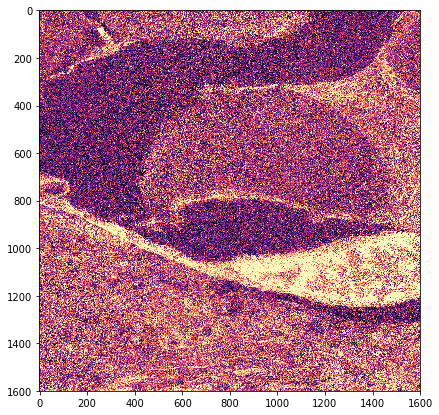

In [85]:
mean, std = np.mean(X), np.std(X)
X = normalize(X, mean, std)

# We concatenate an extra channel filled with zeros. It will be internally used for the masking.
Y = np.concatenate((X, np.zeros(X.shape)), axis=3)

# All training images are noisy:
plt.figure(figsize=(7,7))
plt.imshow(Y[0,...,0], cmap="magma")
print(X.shape, Y.shape)

### Validation Data Preparation

There are two possiblities to build the validation set:

1. Training-Data like: Meaning that the validations loss is only computed on a fixed number of manipulated (masked) pixels. This means that we randomly select a fixed number of pixels before training and manipulate them like it is done for the training data during training. 
2. Test-Data like: Meaning that the validation loss is computed on all pixels of the validation set.
The pixels are __not__ manipulated.
This setup is more like the setup during testing.

In our paper we chose *option 1* to have the same loss during validation as during training. But using *option 2* will result in a more stable validation loss since it is computed over __all__ instead of a subset of pixels.

(1, 256, 256, 1) (1, 256, 256, 2)


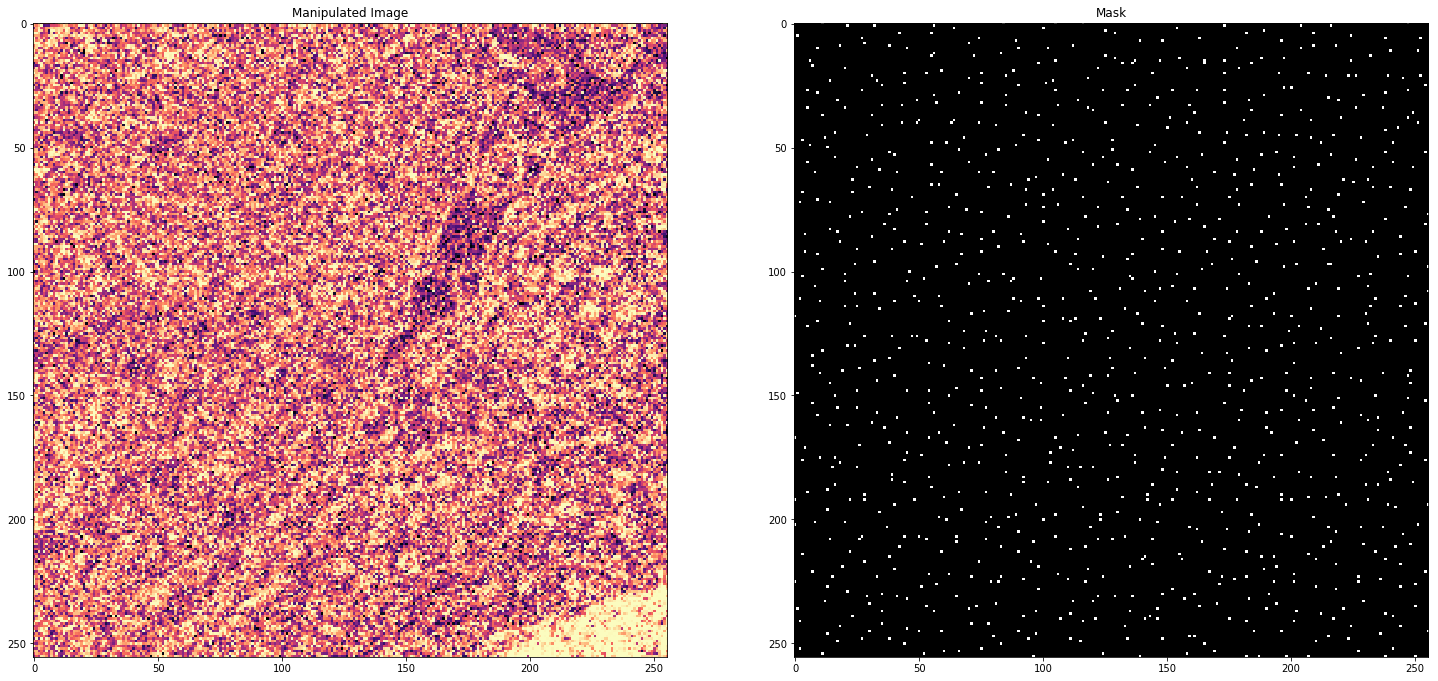

In [86]:
# Load the remaining data as validation data
X_val = imread('data/SEM/train/train.tif')[3,2500:2756,:256].astype(np.float32)
X_val = X_val[np.newaxis,...,np.newaxis]
# We normalize the data using the same mean and standard deviation as for the training
X_val = normalize(X_val, mean, std)

# 1. Option
Y_val = np.concatenate((X_val.copy(), np.zeros(X_val.shape)), axis=3) 
manipulate_val_data(X_val, Y_val,num_pix=256*256/64 , shape=(256, 256))

# 2. Option
#Y_val = np.concatenate((X_val.copy(), np.ones(X_val.shape)), axis=3)

# The validation set is noisy as well:

plt.figure(figsize=(25,25))
plt.subplot(1,2,1)
plt.imshow(X_val[0,...,0], cmap="magma")
plt.title("Manipulated Image")
plt.subplot(1,2,2)
plt.imshow(Y_val[0,...,1], cmap="gray")
plt.title("Mask")
print(X_val.shape, Y_val.shape)

## Training

In [87]:
history = model.train(X,Y, validation_data=(X_val,Y_val))

Epoch 1/100
50/50 [==============================] - 7s 137ms/step - loss: 1.5259 - mse: 1.3640 - mae: 0.9543 - val_loss: 1.2992 - val_mse: 0.9616 - val_mae: 0.7793
Epoch 2/100
50/50 [==============================] - 5s 100ms/step - loss: 1.0005 - mse: 0.7766 - mae: 0.7150 - val_loss: 3.4853 - val_mse: 4.8401 - val_mae: 1.9052
Epoch 3/100
50/50 [==============================] - 5s 99ms/step - loss: 0.9769 - mse: 0.6396 - mae: 0.6488 - val_loss: 1.8348 - val_mse: 2.5535 - val_mae: 1.3318
Epoch 4/100
50/50 [==============================] - 5s 99ms/step - loss: 0.8808 - mse: 0.5942 - mae: 0.6184 - val_loss: 1.2890 - val_mse: 0.7123 - val_mae: 0.6579
Epoch 5/100
50/50 [==============================] - 5s 101ms/step - loss: 0.7957 - mse: 0.6037 - mae: 0.6368 - val_loss: 2.1650 - val_mse: 0.9287 - val_mae: 0.7631
Epoch 6/100
50/50 [==============================] - 5s 101ms/step - loss: 0.8041 - mse: 0.5827 - mae: 0.6182 - val_loss: 1.6795 - val_mse: 0.6191 - val_mae: 0.6178
Epoch 7/100


50/50 [==============================] - 5s 100ms/step - loss: 0.6679 - mse: 0.3782 - mae: 0.5006 - val_loss: 0.6508 - val_mse: 0.4300 - val_mae: 0.5599
Epoch 51/100
50/50 [==============================] - 5s 101ms/step - loss: 0.6582 - mse: 0.3828 - mae: 0.4904 - val_loss: 0.7104 - val_mse: 0.1814 - val_mae: 0.3360
Epoch 52/100
50/50 [==============================] - 5s 100ms/step - loss: 0.7078 - mse: 0.3924 - mae: 0.5248 - val_loss: 0.6461 - val_mse: 0.2991 - val_mae: 0.4547
Epoch 53/100
50/50 [==============================] - 5s 99ms/step - loss: 0.6543 - mse: 0.3622 - mae: 0.5027 - val_loss: 0.6544 - val_mse: 0.2779 - val_mae: 0.4366
Epoch 54/100
50/50 [==============================] - 5s 99ms/step - loss: 0.6403 - mse: 0.3931 - mae: 0.5101 - val_loss: 0.6625 - val_mse: 0.5186 - val_mae: 0.6325
Epoch 55/100
50/50 [==============================] - 5s 99ms/step - loss: 0.7343 - mse: 0.3220 - mae: 0.4702 - val_loss: 0.6417 - val_mse: 0.3869 - val_mae: 0.5350
Epoch 56/100
50/50 [

50/50 [==============================] - 5s 100ms/step - loss: 0.6726 - mse: 0.4022 - mae: 0.5179 - val_loss: 0.6353 - val_mse: 0.2955 - val_mae: 0.4565
Epoch 99/100
50/50 [==============================] - 5s 100ms/step - loss: 0.6588 - mse: 0.3754 - mae: 0.4813 - val_loss: 0.6330 - val_mse: 0.2974 - val_mae: 0.4591
Epoch 100/100
50/50 [==============================] - 5s 99ms/step - loss: 0.6481 - mse: 0.4367 - mae: 0.5506 - val_loss: 0.6353 - val_mse: 0.3101 - val_mae: 0.4695

Loading network weights from 'weights_best.h5'.


['loss', 'lr', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse']


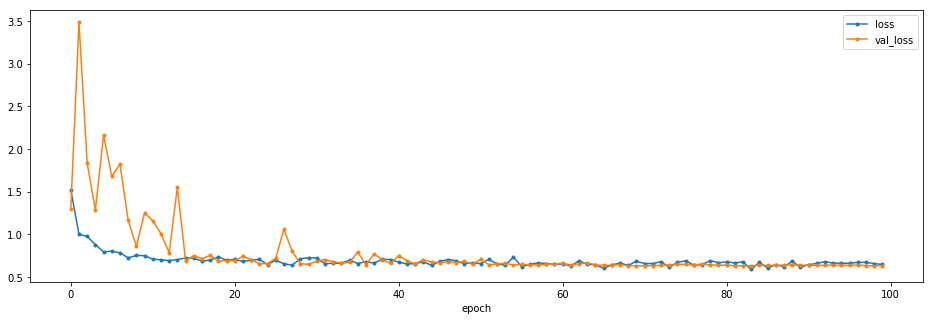

In [93]:
# Lets look at the training and validation loss.

print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

## Evaluation

For the evaluation we load the test low-SNR and ground truth data. Since we have simulated low- and high-SNR images via exposure, we have to normalize the values to compute a meaningful PSNR value. The ground truth data has a simulated exposure of 10'000 and the low-SNR data has an exposure of 20. 

In [99]:
 model.load_weights( name='weights_last.h5')

In [108]:
test_lowSNR = imread('data/SEM/test/test.tif')[:,:,:,np.newaxis]
# normalize data with mean and std of the training data
test_lowSNR = normalize(test_lowSNR, mean, std)

In [109]:
predictions = []
# Denoise all images
for i in range(test_lowSNR.shape[0]):
    predictions.append(denormalize(model.predict(test_lowSNR[i], axes='YXC',normalizer=None ), mean, std))
predictions = np.array(predictions)

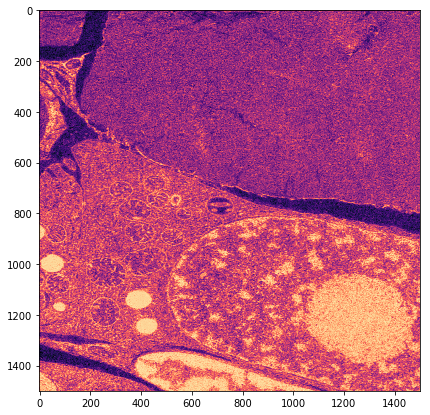

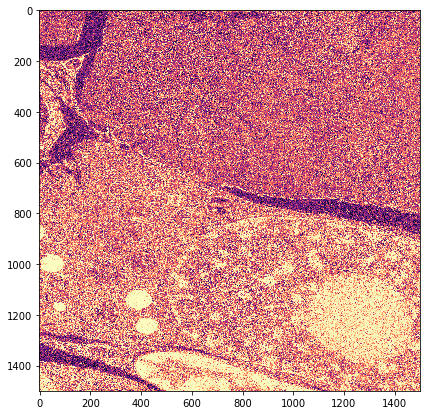

In [112]:
plt.figure(figsize=(7,7))
plt.imshow(predictions[4,:1500,:1500,0],cmap="magma")
plt.show()
plt.figure(figsize=(7,7))
plt.imshow(test_lowSNR[4,:1500:,:1500,0],cmap="magma")